# Task 4: Model Comparison & Selection

# Import necessary libraries


In [3]:

import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from seqeval.metrics import classification_report

In [4]:
# Function to load CONLL format data
def load_conll_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read().strip().split('\n\n')

    sentences, labels = [], []
    for sentence in data:
        words, tags = [], []
        for line in sentence.split('\n'):
            if line.strip():
                try:
                    word, tag = line.split()
                    words.append(word)
                    tags.append(tag)
                except ValueError:
                    print(f"Skipping line due to ValueError: {line}")
        if words and tags:
            sentences.append(words)
            labels.append(tags)

    return sentences, labels

# Function to prepare the dataset for training


In [5]:
def prepare_dataset(sentences, labels):
    df = pd.DataFrame({'tokens': sentences, 'ner_tags': labels})
    dataset = Dataset.from_pandas(df)
    return dataset

# Function to get label encodings


In [6]:
def get_label_encodings():
    label_list = ['O', 'B-Product', 'I-Product', 'B-LOC', 'I-LOC', 'B-Price', 'I-Price']
    label2id = {label: id for id, label in enumerate(label_list)}
    id2label = {id: label for label, id in label2id.items()}
    return label_list, label2id, id2label



# Function to load model and tokenizer


In [7]:
def load_model_and_tokenizer(model_name, num_labels, id2label, label2id):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    return tokenizer, model

# Function to tokenize and align labels


In [8]:
def tokenize_and_align_labels(examples, tokenizer, label2id, max_length=128):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding='max_length',
        max_length=max_length,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id.get(label[word_idx], -100))
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Function to set up the trainer


In [9]:
def setup_trainer(model, tokenizer, train_dataset, eval_dataset, output_dir):
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
    )

    return trainer

In [10]:
# Tokenize and align the dataset
def tokenize_and_align_dataset(dataset, tokenizer, label2id):
    tokenized_dataset = dataset.map(
        lambda examples: tokenize_and_align_labels(examples, tokenizer, label2id),
        batched=True,
        remove_columns=dataset.column_names
    )
    return tokenized_dataset

# Function to fine-tune and evaluate the model


In [11]:
# Finetune and evaluate each model
def finetune_and_evaluate(model_name, train_dataset, eval_dataset, label_list, label2id, id2label):
    tokenizer, model = load_model_and_tokenizer(model_name, len(label_list), id2label, label2id)

    # Tokenize the datasets
    train_tokenized = tokenize_and_align_dataset(train_dataset, tokenizer, label2id)
    eval_tokenized = tokenize_and_align_dataset(eval_dataset, tokenizer, label2id)

    output_dir = f"./results_{model_name.split('/')[-1]}"
    trainer = setup_trainer(model, tokenizer, train_tokenized, eval_tokenized, output_dir)

    # Fine-tuning the model and measure time
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    # Evaluation
    eval_results = trainer.evaluate()

    # Compute predictions
    predictions = trainer.predict(eval_tokenized)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids

    # Get classification report
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(preds, labels)
    ]

    report = classification_report(true_labels, true_predictions)

    return {
        "model_name": model_name,
        "eval_loss": eval_results["eval_loss"],
        "training_time": training_time,
        "classification_report": report,
        "model": model,
        "tokenizer": tokenizer
    }

# Function to predict NER


In [12]:
def predict_ner(text, model, tokenizer, id2label):
    model.eval()
    device = next(model.parameters()).device

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)

    predicted_labels = [id2label[prediction.item()] for prediction in predictions[0]]
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    return list(zip(tokens, predicted_labels))

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!cp /content/drive/MyDrive/merged_amharic_ner_data.conll /content/


# Load and prepare data


In [15]:
file_path = '/content/drive/MyDrive/merged_amharic_ner_data.conll'
sentences, labels = load_conll_data(file_path)
train_sentences, eval_sentences, train_labels, eval_labels = train_test_split(sentences, labels, test_size=0.2)


# Prepare dataset


In [16]:
train_dataset = prepare_dataset(train_sentences, train_labels)
eval_dataset = prepare_dataset(eval_sentences, eval_labels)

# Get label encodings


In [17]:
label_list, label2id, id2label = get_label_encodings()

# Model names to compare


In [18]:
model_names = [
    'xlm-roberta-base',  # Example: XLM-Roberta
    'distilbert-base-uncased',  # Example: DistilBERT
    'bert-base-multilingual-cased',  # Example: mBERT
]

# Comparing models


In [19]:
results = []
for model_name in model_names:
    print(f"Fine-tuning model:")
    result = finetune_and_evaluate(model_name, train_dataset, eval_dataset, label_list, label2id, id2label)
    results.append(result)

Fine-tuning model:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5160 [00:00<?, ? examples/s]

Map:   0%|          | 0/1290 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.022876
2,0.087600,0.012406
3,0.087600,0.009764


Fine-tuning model:


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5160 [00:00<?, ? examples/s]

Map:   0%|          | 0/1290 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.128810
2,0.223400,0.091695
3,0.223400,0.081368


Fine-tuning model:


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5160 [00:00<?, ? examples/s]

Map:   0%|          | 0/1290 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.102049
2,0.192000,0.069567
3,0.192000,0.059760


# Display results


Model: xlm-roberta-base
Evaluation Loss: 0.009764409624040127
Training Time: 510.84 seconds
Classification Report:
              precision    recall  f1-score   support

         LOC       0.98      0.98      0.98      1524
       Price       0.90      0.98      0.94        54
     Product       0.74      0.83      0.79       289

   micro avg       0.94      0.96      0.95      1867
   macro avg       0.88      0.93      0.90      1867
weighted avg       0.95      0.96      0.95      1867

Model: distilbert-base-uncased
Evaluation Loss: 0.0813683345913887
Training Time: 204.61 seconds
Classification Report:
              precision    recall  f1-score   support

         LOC       0.74      0.63      0.68      2107
       Price       0.67      0.85      0.75        54
     Product       0.88      0.55      0.68       331

   micro avg       0.76      0.63      0.69      2492
   macro avg       0.76      0.68      0.70      2492
weighted avg       0.76      0.63      0.68      2492

Mod

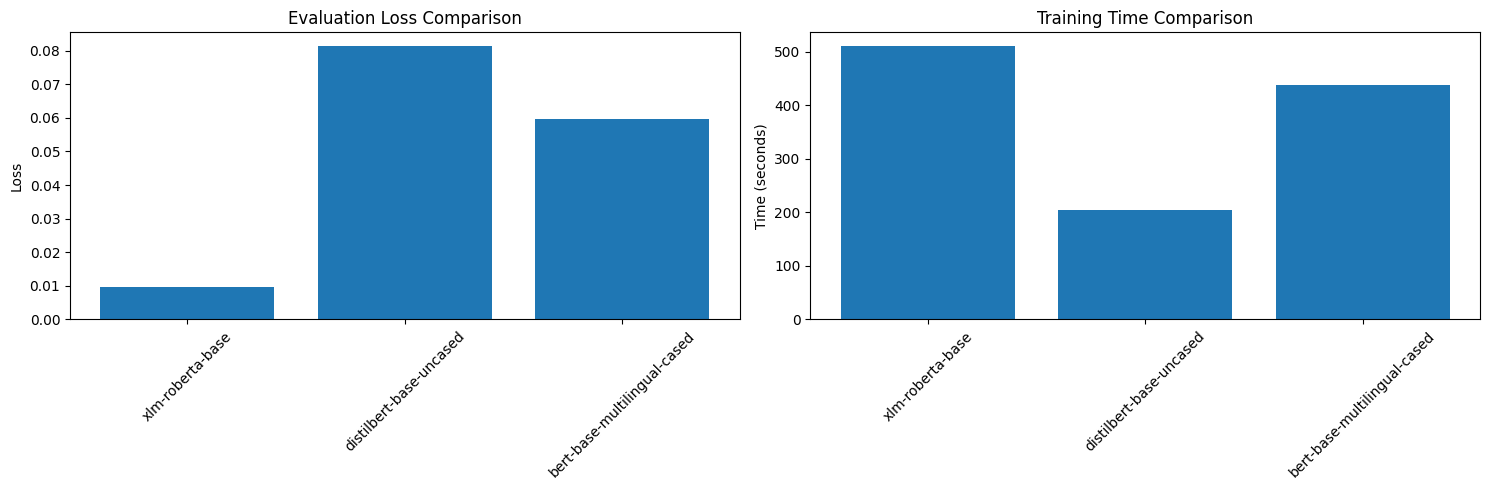

In [25]:
import matplotlib.pyplot as plt

# Initialize empty lists to store the model names, evaluation losses, and training times
model_names = []
eval_losses = []
training_times = []

# Assuming 'results' contains the evaluation data and model comparison
for result in results:
    model_names.append(result['model_name'])         # Append model name
    eval_losses.append(result['eval_loss'])          # Append evaluation loss
    training_times.append(result['training_time'])   # Append training time

    # Printing details for each model
    print(f"Model: {result['model_name']}")
    print(f"Evaluation Loss: {result['eval_loss']}")
    print(f"Training Time: {result['training_time']:.2f} seconds")
    print("Classification Report:")
    print(result['classification_report'])
    print("=" * 50)

# Create subplots for evaluation loss and training time comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Evaluation Loss Comparison
ax1.bar(model_names, eval_losses)
ax1.set_title('Evaluation Loss Comparison')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='x', rotation=45)

# Plotting Training Time Comparison
ax2.bar(model_names, training_times)
ax2.set_title('Training Time Comparison')
ax2.set_ylabel('Time (seconds)')
ax2.tick_params(axis='x', rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('model_comparison_results.png')
print("Results visualization saved as 'model_comparison_results.png'")


## Select the best model based on evaluation loss or another metric


In [26]:
best_model = min(results, key=lambda x: x['eval_loss'])
print(f"The best model is: {best_model['model_name']} with an evaluation loss of {best_model['eval_loss']:.4f}.")

The best model is: xlm-roberta-base with an evaluation loss of 0.0098.
